# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups      
Sample_201  P17931                 15.937
Sample_068  E9PNW4;E9PR17;P13987   19.978
Sample_174  Q8NBI6                 15.521
Sample_123  Q02818                 17.873
Sample_167  P01009                 26.261
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups
Sample_180  P19835;X6R868    15.176
Sample_019  E7EQ64;P07477    16.674
Sample_046  P01743           13.177
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.932
            A0A075B6Q5                 12.759
            A0A075B6R2                 13.179
            A0A075B6S5                 12.424
            A0A087WSY4                 13.341
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.176
            Q9UI40;Q9UI40-2            12.927
            Q9UIW2                     13.109
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.208
            Q9UP79                     12.157
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.231,15.050,16.842,19.863,15.895,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.717,19.067,...,15.528,15.576,14.158,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.856,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.267,17.705,17.039,16.076,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.901,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.661,15.345,17.084,18.708,14.249,19.433,11.263,11.175
Sample_207,15.739,16.877,15.469,16.898,15.061,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.968,13.408,12.187,13.058,14.476,13.185,13.089,11.915,12.885,12.591
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.177,19.067,16.127,...,12.673,13.076,13.416,11.448,12.846,11.837,13.947,13.730,13.000,13.369
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.501,12.891,12.356,12.025,13.361,11.688,12.711,11.828,14.026,12.007
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.215,13.780,13.250,13.180,13.058,13.744,13.327,13.122,13.263,13.792
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.623,13.016,13.090,13.433,13.976,12.346,13.662,13.584,12.460,11.916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.897,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 261.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.76it/s]

100%|██████████| 2/2 [00:00<00:00,  7.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.02it/s]

100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.92it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.84it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.64it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.04it/s]

100%|██████████| 5/5 [00:01<00:00,  4.03it/s]

100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.28it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.98it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.31it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.94it/s]

100%|██████████| 6/6 [00:01<00:00,  2.61it/s]

100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.24it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.13it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.77it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.28it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.86it/s]

100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.68it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.54it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.08it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.72it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.47it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.85it/s]

100%|██████████| 8/8 [00:01<00:00,  3.47it/s]

100%|██████████| 8/8 [00:01<00:00,  4.19it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.28it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.43it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.59it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.54it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.47it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.48it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.86it/s]

100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

100%|██████████| 9/9 [00:02<00:00,  4.21it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.89it/s]

 30%|███       | 3/10 [00:00<00:01,  6.52it/s]

 40%|████      | 4/10 [00:00<00:01,  5.27it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.24it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.17it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.30it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.23it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.32it/s]

100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.64it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.78it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.14it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.96it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.14it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.95it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.93it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.05it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.59it/s]

100%|██████████| 11/11 [00:02<00:00,  3.24it/s]

100%|██████████| 11/11 [00:02<00:00,  4.00it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.27it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.23it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.21it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.87it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.90it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.29it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.16it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.03it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.08it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.64it/s]

100%|██████████| 12/12 [00:02<00:00,  3.35it/s]

100%|██████████| 12/12 [00:02<00:00,  4.16it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.43it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.46it/s]

 31%|███       | 4/13 [00:00<00:01,  5.34it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.92it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.69it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.63it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.47it/s]

 69%|██████▉   | 9/13 [00:01<00:01,  3.99it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.82it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.83it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.39it/s]

100%|██████████| 13/13 [00:03<00:00,  3.24it/s]

100%|██████████| 13/13 [00:03<00:00,  4.08it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.73it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.90it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.70it/s]

 36%|███▌      | 5/14 [00:01<00:01,  4.57it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.35it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.40it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.30it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.29it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.18it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.71it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.76it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.75it/s]

100%|██████████| 14/14 [00:03<00:00,  3.75it/s]

100%|██████████| 14/14 [00:03<00:00,  4.16it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.51it/s]

 20%|██        | 3/15 [00:00<00:02,  4.61it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.83it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.57it/s]

 40%|████      | 6/15 [00:01<00:02,  3.30it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.09it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.12it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.23it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.11it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.27it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.45it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.47it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.65it/s]

100%|██████████| 15/15 [00:04<00:00,  3.55it/s]

100%|██████████| 15/15 [00:04<00:00,  3.52it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.049 0.019          0.771 0.335       0.122   
2             0.005 0.003      0.046 0.017          0.635 0.150       0.465   
3             0.004 0.002      0.042 0.014          0.814 0.085       0.717   
4             0.006 0.006      0.049 0.017          0.813 0.081       0.771   
5             0.004 0.002      0.045 0.014          0.828 0.080       0.793   
6             0.003 0.000      0.046 0.014          0.831 0.082       0.790   
7             0.006 0.008      0.058 0.025          0.827 0.084       0.788   
8             0.004 0.003      0.052 0.021          0.837 0.076       0.833   
9             0.004 0.004      0.046 0.018          0.839 0.078       0.825   
10            0.005 0.003      0.053 0.019          0.840 0.077       0.824   
11            0.005 0.006      0.047 0.017          0.847 0.070       0.814   
12            0.004 0.003      0.052 0.019          0.835 0.082       0.805   
13            0.005 0.003      0.045 0.012          0.826 0.085       0.802   
14            0.006 0.004      0.054 0.020          0.823 0.085       0.795   
15            0.005 0.003      0.051 0.018          0.823 0.081       0.788   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.204 0.126                  0.553 0.040        0.849   
2          0.117   0.525 0.101                  0.627 0.069        0.701   
3          0.099   0.757 0.067                  0.796 0.054        0.895   
4          0.104   0.786 0.068                  0.819 0.055        0.906   
5          0.089   0.806 0.063                  0.835 0.053        0.909   
6          0.089   0.806 0.064                  0.834 0.054        0.908   
7          0.093   0.802 0.066                  0.832 0.055        0.906   
8          0.095   0.832 0.068                  0.857 0.058        0.919   
9          0.095   0.829 0.067                  0.854 0.058        0.919   
10         0.093   0.828 0.067                  0.854 0.057        0.919   
11         0.083   0.827 0.057                  0.852 0.047        0.924   
12         0.103   0.815 0.075                  0.843 0.060        0.922   
13         0.100   0.810 0.076                  0.838 0.062        0.920   
14         0.100   0.805 0.075                  0.834 0.062        0.918   
15         0.094   0.801 0.067                  0.831 0.056        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.089        210.000 0.000  
2          0.081                  0.654 0.097        210.000 0.000  
3          0.044                  0.876 0.054        210.000 0.000  
4          0.044                  0.884 0.053        210.000 0.000  
5          0.047                  0.893 0.055        210.000 0.000  
6          0.048                  0.892 0.056        210.000 0.000  
7          0.048                  0.889 0.056        210.000 0.000  
8          0.044                  0.905 0.049        210.000 0.000  
9          0.044                  0.908 0.049        210.000 0.000  
10         0.045                  0.907 0.049        210.000 0.000  
11         0.047                  0.913 0.049        210.000 0.000  
12         0.049                  0.911 0.051        210.000 0.000  
13         0.048                  0.910 0.049        210.000 0.000  
14         0.048                  0.908 0.050        210.000 0.000  
15         0.048                  0.906 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 489.87it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.68it/s]

100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.31it/s]

100%|██████████| 4/4 [00:00<00:00,  3.82it/s]

100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.74it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.91it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.60it/s]

100%|██████████| 5/5 [00:01<00:00,  4.18it/s]

100%|██████████| 5/5 [00:01<00:00,  4.48it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.32it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.35it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.14it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.22it/s]

100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.78it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.34it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.19it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.89it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.01it/s]

100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.70it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.26it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.64it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.32it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.07it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.99it/s]

100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

100%|██████████| 8/8 [00:03<00:00,  2.31it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.75it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.70it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.07it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.01it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.21it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.84it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.87it/s]

100%|██████████| 9/9 [00:02<00:00,  2.70it/s]

100%|██████████| 9/9 [00:02<00:00,  3.19it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.86it/s]

 30%|███       | 3/10 [00:00<00:01,  4.98it/s]

 40%|████      | 4/10 [00:00<00:01,  3.66it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.13it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.71it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.38it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.22it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.12it/s]

100%|██████████| 10/10 [00:03<00:00,  2.32it/s]

100%|██████████| 10/10 [00:03<00:00,  2.68it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.73it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.77it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.11it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.89it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.63it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.46it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.97it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.88it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.75it/s]

100%|██████████| 11/11 [00:03<00:00,  2.72it/s]

100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.42it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.43it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.64it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.07it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.42it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  2.99it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.81it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.68it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.81it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.60it/s]

100%|██████████| 12/12 [00:03<00:00,  2.45it/s]

100%|██████████| 12/12 [00:03<00:00,  3.04it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.74it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.37it/s]

 31%|███       | 4/13 [00:01<00:02,  3.12it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.10it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.05it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.95it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.94it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.13it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.35it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.30it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.18it/s]

100%|██████████| 13/13 [00:04<00:00,  2.92it/s]

100%|██████████| 13/13 [00:04<00:00,  3.10it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.79it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.29it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.86it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.87it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.71it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.75it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.60it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.67it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.69it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.74it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.43it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.99it/s]

100%|██████████| 14/14 [00:03<00:00,  2.94it/s]

100%|██████████| 14/14 [00:04<00:00,  3.49it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.57it/s]

 20%|██        | 3/15 [00:00<00:02,  5.40it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.85it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.44it/s]

 40%|████      | 6/15 [00:01<00:02,  3.52it/s]

 47%|████▋     | 7/15 [00:01<00:02,  2.87it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.70it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.62it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.94it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.11it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.23it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.26it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.37it/s]

100%|██████████| 15/15 [00:04<00:00,  3.39it/s]

100%|██████████| 15/15 [00:04<00:00,  3.40it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.053 0.020          0.010 0.071       0.001   
2             0.005 0.005      0.060 0.024          0.601 0.208       0.232   
3             0.004 0.003      0.049 0.017          0.755 0.114       0.511   
4             0.003 0.000      0.035 0.005          0.771 0.089       0.613   
5             0.003 0.001      0.030 0.007          0.744 0.110       0.640   
6             0.003 0.002      0.038 0.014          0.815 0.089       0.789   
7             0.004 0.003      0.045 0.015          0.823 0.090       0.797   
8             0.005 0.006      0.050 0.020          0.823 0.089       0.795   
9             0.006 0.007      0.059 0.026          0.824 0.089       0.795   
10            0.004 0.003      0.048 0.016          0.832 0.091       0.814   
11            0.005 0.004      0.062 0.028          0.833 0.090       0.807   
12            0.005 0.005      0.049 0.020          0.834 0.092       0.803   
13            0.006 0.005      0.063 0.025          0.829 0.092       0.803   
14            0.005 0.005      0.050 0.019          0.831 0.091       0.806   
15            0.004 0.000      0.041 0.011          0.839 0.084       0.800   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.861   
2          0.118   0.317 0.132                  0.558 0.044        0.695   
3          0.108   0.604 0.098                  0.694 0.065        0.702   
4          0.118   0.677 0.094                  0.740 0.066        0.813   
5          0.108   0.683 0.089                  0.737 0.069        0.810   
6          0.103   0.797 0.074                  0.827 0.060        0.899   
7          0.101   0.805 0.073                  0.834 0.061        0.899   
8          0.100   0.804 0.073                  0.833 0.060        0.897   
9          0.112   0.804 0.081                  0.834 0.068        0.921   
10         0.110   0.818 0.082                  0.846 0.069        0.924   
11         0.113   0.815 0.081                  0.843 0.067        0.924   
12         0.114   0.813 0.081                  0.841 0.067        0.922   
13         0.115   0.810 0.083                  0.839 0.069        0.921   
14         0.112   0.813 0.078                  0.841 0.065        0.921   
15         0.110   0.814 0.077                  0.843 0.063        0.924   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.828 0.087        210.000 0.000  
2          0.101                  0.614 0.116        210.000 0.000  
3          0.073                  0.711 0.082        210.000 0.000  
4          0.065                  0.786 0.083        210.000 0.000  
5          0.070                  0.785 0.088        210.000 0.000  
6          0.048                  0.886 0.054        210.000 0.000  
7          0.050                  0.884 0.057        210.000 0.000  
8          0.049                  0.883 0.056        210.000 0.000  
9          0.045                  0.901 0.053        210.000 0.000  
10         0.044                  0.905 0.051        210.000 0.000  
11         0.044                  0.905 0.051        210.000 0.000  
12         0.045                  0.903 0.052        210.000 0.000  
13         0.045                  0.902 0.051        210.000 0.000  
14         0.045                  0.902 0.052        210.000 0.000  
15         0.043                  0.908 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1007.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 28.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 24.84it/s]

100%|██████████| 3/3 [00:00<00:00, 24.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 24.00it/s]

100%|██████████| 4/4 [00:00<00:00, 22.00it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.99it/s]

100%|██████████| 5/5 [00:00<00:00, 18.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.03it/s]

100%|██████████| 6/6 [00:00<00:00, 15.51it/s]

100%|██████████| 6/6 [00:00<00:00, 16.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 24.16it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 18.14it/s]

100%|██████████| 7/7 [00:00<00:00, 18.33it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.62it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.45it/s]

100%|██████████| 8/8 [00:00<00:00, 15.67it/s]

100%|██████████| 8/8 [00:00<00:00, 16.18it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.85it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.78it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.65it/s]

100%|██████████| 9/9 [00:00<00:00, 16.96it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.39it/s]

 60%|██████    | 6/10 [00:00<00:00, 20.23it/s]

 90%|█████████ | 9/10 [00:00<00:00, 17.80it/s]

100%|██████████| 10/10 [00:00<00:00, 17.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.78it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.45it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 14.94it/s]

 91%|█████████ | 10/11 [00:00<00:00, 15.39it/s]

100%|██████████| 11/11 [00:00<00:00, 15.37it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.43it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.65it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 16.54it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.81it/s]

100%|██████████| 12/12 [00:00<00:00, 16.62it/s]

100%|██████████| 12/12 [00:00<00:00, 16.98it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 17.88it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.62it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.10it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.81it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.19it/s]

100%|██████████| 13/13 [00:00<00:00, 12.78it/s]

100%|██████████| 13/13 [00:00<00:00, 13.35it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.74it/s]

 43%|████▎     | 6/14 [00:00<00:00, 13.46it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 13.05it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.34it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 11.77it/s]

100%|██████████| 14/14 [00:01<00:00, 10.57it/s]

100%|██████████| 14/14 [00:01<00:00, 11.90it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 23.17it/s]

 47%|████▋     | 7/15 [00:00<00:00, 21.11it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 19.81it/s]

 80%|████████  | 12/15 [00:00<00:00, 17.43it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 16.13it/s]

100%|██████████| 15/15 [00:00<00:00, 18.05it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.053 0.021          0.000 0.000       0.000   
2             0.003 0.001      0.040 0.011          0.672 0.096       0.502   
3             0.005 0.004      0.050 0.019          0.631 0.113       0.475   
4             0.005 0.004      0.043 0.014          0.632 0.114       0.467   
5             0.004 0.003      0.046 0.017          0.692 0.095       0.570   
6             0.005 0.005      0.048 0.019          0.691 0.092       0.578   
7             0.005 0.004      0.051 0.021          0.681 0.082       0.580   
8             0.006 0.008      0.047 0.015          0.680 0.087       0.575   
9             0.004 0.002      0.049 0.019          0.683 0.089       0.590   
10            0.005 0.003      0.052 0.022          0.693 0.080       0.646   
11            0.005 0.004      0.052 0.019          0.692 0.079       0.642   
12            0.006 0.006      0.054 0.027          0.678 0.082       0.624   
13            0.004 0.003      0.044 0.015          0.688 0.085       0.634   
14            0.005 0.003      0.062 0.026          0.704 0.073       0.664   
15            0.005 0.003      0.047 0.016          0.698 0.080       0.651   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.739   
2          0.098   0.568 0.080                  0.658 0.055        0.731   
3          0.097   0.534 0.084                  0.631 0.061        0.737   
4          0.100   0.529 0.086                  0.630 0.060        0.733   
5          0.099   0.619 0.081                  0.690 0.060        0.783   
6          0.103   0.622 0.076                  0.692 0.056        0.789   
7          0.104   0.620 0.075                  0.689 0.055        0.790   
8          0.101   0.618 0.079                  0.688 0.059        0.790   
9          0.110   0.628 0.086                  0.694 0.065        0.787   
10         0.115   0.664 0.085                  0.718 0.067        0.813   
11         0.116   0.661 0.084                  0.716 0.066        0.808   
12         0.118   0.645 0.086                  0.703 0.068        0.807   
13         0.108   0.655 0.081                  0.710 0.065        0.806   
14         0.104   0.678 0.072                  0.729 0.057        0.812   
15         0.112   0.668 0.079                  0.722 0.061        0.810   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.690 0.085        210.000 0.000  
2          0.072                  0.659 0.093        210.000 0.000  
3          0.077                  0.661 0.094        210.000 0.000  
4          0.076                  0.661 0.090        210.000 0.000  
5          0.068                  0.731 0.081        210.000 0.000  
6          0.065                  0.737 0.073        210.000 0.000  
7          0.063                  0.739 0.068        210.000 0.000  
8          0.065                  0.737 0.071        210.000 0.000  
9          0.065                  0.740 0.069        210.000 0.000  
10         0.059                  0.764 0.068        210.000 0.000  
11         0.059                  0.760 0.069        210.000 0.000  
12         0.058                  0.760 0.066        210.000 0.000  
13         0.057                  0.757 0.066        210.000 0.000  
14         0.055                  0.767 0.068        210.000 0.000  
15         0.056                  0.764 0.070 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,13,8
score_time,7,13,14
test_precision,11,15,14
test_recall,8,10,14
test_f1,8,10,14
test_balanced_accuracy,8,10,14
test_roc_auc,11,15,10
test_average_precision,11,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.41it/s]

 20%|██        | 3/15 [00:00<00:02,  5.18it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.70it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.18it/s]

 40%|████      | 6/15 [00:01<00:03,  2.89it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.64it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.81it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.99it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.20it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.47it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.58it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.66it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.68it/s]

100%|██████████| 15/15 [00:04<00:00,  4.12it/s]

100%|██████████| 15/15 [00:04<00:00,  3.53it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 25.07it/s]

 70%|███████   | 7/10 [00:00<00:00, 22.03it/s]

100%|██████████| 10/10 [00:00<00:00, 20.02it/s]

100%|██████████| 10/10 [00:00<00:00, 20.78it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.79it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.86it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.94it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.44it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.08it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.26it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.42it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.40it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.37it/s]

100%|██████████| 11/11 [00:03<00:00,  3.43it/s]

100%|██████████| 11/11 [00:03<00:00,  3.59it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


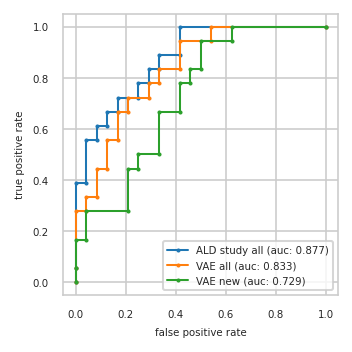

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.389   0.000 0.278   0.000 0.167
3          0.042 0.389   0.042 0.278   0.042 0.167
4          0.042 0.556   0.042 0.333   0.042 0.278
5          0.083 0.556   0.083 0.333   0.208 0.278
6          0.083 0.611   0.083 0.444   0.208 0.444
7          0.125 0.611   0.125 0.444   0.250 0.444
8          0.125 0.667   0.125 0.556   0.250 0.500
9          0.167 0.667   0.167 0.556   0.333 0.500
10         0.167 0.722   0.167 0.667   0.333 0.667
11         0.250 0.722   0.208 0.667   0.417 0.667
12         0.250 0.778   0.208 0.722   0.417 0.778
13         0.292 0.778   0.292 0.722   0.458 0.778
14         0.292 0.833   0.292 0.778   0.458 0.833
15         0.333 0.833   0.333 0.778   0.500 0.833
16         0.333 0.889   0.333 0.833   0.500 0.944
17         0.417 0.889   0.417 0.833   0.625 0.944
18         0.417 1.000   0.417 0.944   0.625 1.000
19         1.000 1.000   0.542 0.944   1.000 1.000
20           NaN   NaN   0.542 1.000     NaN   NaN
21           NaN   NaN   1.000 1.000     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,K7ER15;Q9H0R4;Q9H0R4-2,A0A087WXB8;Q9Y274
2,P09486,P02741,P51688
3,A6NFX8;Q9UKK9,P61981,J3KSJ8;Q9UD71;Q9UD71-2
4,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P14174,P04075,P31321
6,P61981,Q14894,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,Q9Y2T3;Q9Y2T3-3,P14174,E9PK25;G3V1A4;P23528
8,P63104,P63104,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


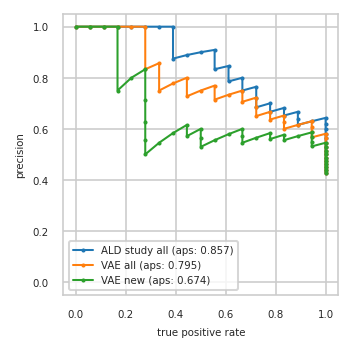

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.567 0.944     0.567 0.944
13         0.621 1.000     0.586 0.944     0.586 0.944
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.640 0.889     0.600 0.833     0.560 0.778
18         0.667 0.889     0.625 0.833     0.583 0.778
19         0.652 0.833     0.652 0.833     0.565 0.722
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.667 0.778     0.667 0.778     0.571 0.667
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.722 0.722     0.722 0.722     0.556 0.556
25         0.765 0.722     0.706 0.667     0.529 0.500
26         0.750 0.667     0.750 0.667     0.562 0.500
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.786 0.611     0.714 0.556     0.571 0.444
29         0.846 0.611     0.769 0.556     0.615 0.444
30         0.833 0.556     0.750 0.500     0.583 0.389
31         0.909 0.556     0.727 0.444     0.545 0.333
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.778 0.389     0.556 0.278
34         0.875 0.389     0.750 0.333     0.625 0.278
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


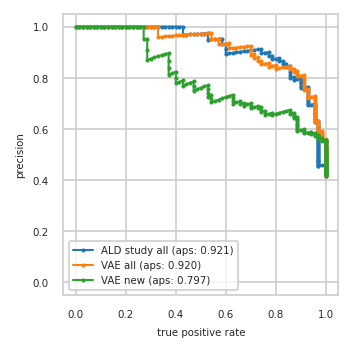

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


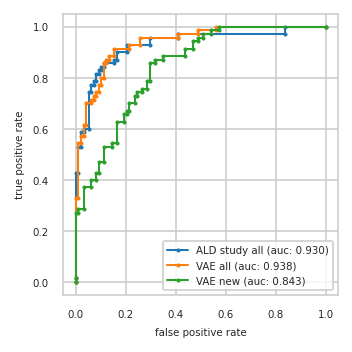

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}